In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from geopy import distance
import tensorflow as tf

2022-12-05 18:54:24.693269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATA_PATH = './data' 
TRAIN_FILE_NAME = 'train_set.csv'
TEST_FILE_NAME = 'test_set.csv'

TRAIN_PATH = os.path.join(DATA_PATH, TRAIN_FILE_NAME)
TEST_PATH = os.path.join(DATA_PATH, TEST_FILE_NAME)

# 1. Análisis exploratorio

## 1.1 Carga de datos

In [4]:
def fetch_from_kaggle(data_path: str, file_name: str):
    from kaggle import KaggleApi
    import zipfile
    
    kaggle_client = KaggleApi()
    kaggle_client.authenticate()
    kaggle_client.competition_download_file(competition='ds-programming-test', file_name=file_name, path=data_path)
    
    zip_path = f'{data_path}/{file_name}.zip'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_path)

    os.remove(zip_path)

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

if not os.path.exists(TRAIN_PATH):    
    fetch_from_kaggle(DATA_PATH, TRAIN_FILE_NAME)

if not os.path.exists(TEST_PATH):    
    fetch_from_kaggle(DATA_PATH, TEST_FILE_NAME)

cleaning_pipe = []

In [5]:
train_raw = pd.read_csv(TRAIN_PATH)
train_raw.describe()

/Users/aast/opt/anaconda3/envs/dl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,trip_id,duration,start_lat,start_lon,end_lat,end_lon,plan_duration,start_station,end_station
count,7.000000e+05,700000.000000,694437.000000,694437.000000,681426.000000,681426.000000,699792.000000,700000.000000,700000.000000
mean,1.069468e+08,37.084979,34.044952,-118.253849,34.044175,-118.259183,44.928697,3499.720464,3489.726771
std,4.497342e+07,125.302510,0.325255,2.332640,0.299721,2.129781,92.816296,615.918795,613.040769
min,8.369648e+06,1.000000,33.710979,-118.495422,33.710979,-118.495422,0.000000,3000.000000,3000.000000
25%,7.538051e+07,7.000000,34.037460,-118.280952,34.037048,-118.280952,1.000000,3031.000000,3030.000000
50%,1.179410e+08,13.000000,34.046612,-118.256980,34.046520,-118.256981,30.000000,3064.000000,3064.000000
75%,1.404178e+08,26.000000,34.051941,-118.247162,34.050911,-118.246422,30.000000,4214.000000,4214.000000
max,1.794831e+08,1440.000000,55.705528,118.238258,55.705528,37.606541,999.000000,4594.000000,4594.000000


In [6]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


## 1.2 Limpieza

In [7]:
train_raw[train_raw.isnull().any(1)]

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
40,110113350,1440,2018-11-23 09:37:00,2018-11-24 16:44:00,34.014309,-118.491341,NaN,NaN,12227,1.0,One Way,Walk-up,4215,3000
92,138318300,14,2/28/2020 13:45,2/28/2020 13:59,NaN,NaN,34.158321,-118.370811,15252,30.0,One Way,Monthly Pass,4285,4413
93,124411714,40,2019-06-27 09:34:00,2019-06-27 10:14:00,NaN,NaN,33.996239,-118.477448,16203,365.0,One Way,Walk-up,4286,4349
102,137685616,17,2/18/2020 13:15,2/18/2020 13:32,33.984341,-118.471550,NaN,NaN,16224,1.0,One Way,Walk-up,4346,4285
116,151343330,21,12/22/2020 14:57,12/22/2020 15:18,34.064281,-118.238937,34.047749,-118.243172,18590,30.0,One Way,NaN,3078,3062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699859,106383965,4,2018-09-30 11:32:00,2018-09-30 11:36:00,34.053200,-118.250954,NaN,NaN,12364,1.0,One Way,Walk-up,3068,3000
699870,130378020,17,2019-10-06 21:18:16,2019-10-06 21:35:12,NaN,NaN,NaN,NaN,16059,30.0,Round Trip,Monthly Pass,4286,4286
699876,168280913,1440,8/7/2021 14:52,8/9/2021 8:52,34.075611,-118.291862,NaN,NaN,6607,30.0,One Way,Monthly Pass,4401,3000
699884,176141786,30,11/13/2021 9:10,11/13/2021 9:40,33.928459,-118.435204,NaN,NaN,13831,1.0,One Way,Walk-up,4544,3000


In [8]:
# Se rellenan las localizaciones NaN con la ubicación de las estaciones vista en otros registros

start_stations = train_raw[['start_lat', 'start_lon', 'start_station']] \
    .dropna(subset=['start_lat', 'start_lon', 'start_station']) \
    .groupby(by='start_station') \
    .first() \
    .reset_index() \
    .rename(columns={
        'start_station': 'station',
        'start_lat': 'lat',
        'start_lon': 'lon'
    })
end_stations = train_raw[['end_lat', 'end_lon', 'end_station']]\
    .dropna(subset=['end_lat', 'end_lon', 'end_station'])\
    .groupby(by='end_station')\
    .first()\
    .reset_index()\
    .rename(columns={
        'end_station': 'station',
        'end_lat': 'lat',
        'end_lon': 'lon'
    })

stations = pd.concat([start_stations, end_stations], axis=0)

def fill_nan_locations(data: pd.DataFrame):
    global stations
    mod_data = data[data.isna().any(1)]
    
    def rep(row: pd.Series):
        start_station = stations[stations['station'] == row['start_station']]
        end_station = stations[stations['station'] == row['end_station']]
        
        if start_station.shape[0] > 0:
            row['start_lat'] = start_station.iloc[0]['lat']
            row['start_lon'] = start_station.iloc[0]['lon']
        
        if end_station.shape[0] > 0:
            row['end_lat'] = end_station.iloc[0]['lat']
            row['end_lon'] = end_station.iloc[0]['lon']

        return row

    
    return data.combine_first(mod_data.apply(rep, axis=1))

cleaning_pipe.append(fill_nan_locations)
train = fill_nan_locations(train_raw)
train

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,83666862,17,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,30.0,One Way,Monthly Pass,3032,4220
699996,132547303,9,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,30.0,One Way,Monthly Pass,3036,3014
699997,67332628,6,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,365.0,One Way,Flex Pass,3032,3007
699998,114846232,3,2019-02-04 14:16:00,2019-02-04 14:19:00,34.045181,-118.250237,34.045540,-118.256668,12195,1.0,One Way,Walk-up,3067,3006


Se buscan los puntos del dataset que podrían no estar dentro del area de servicio (errores de ubicación)

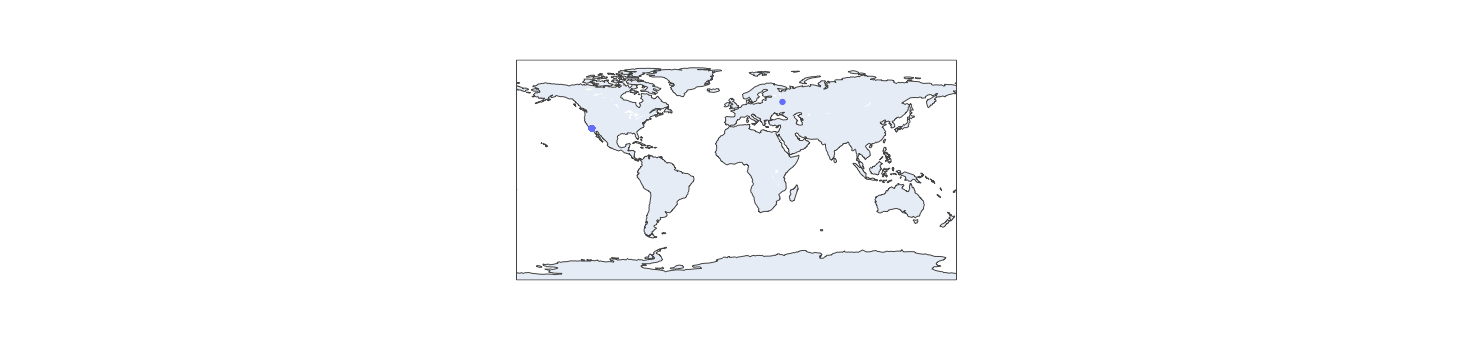

In [9]:
px.scatter_geo(stations, lat='lat', lon='lon')

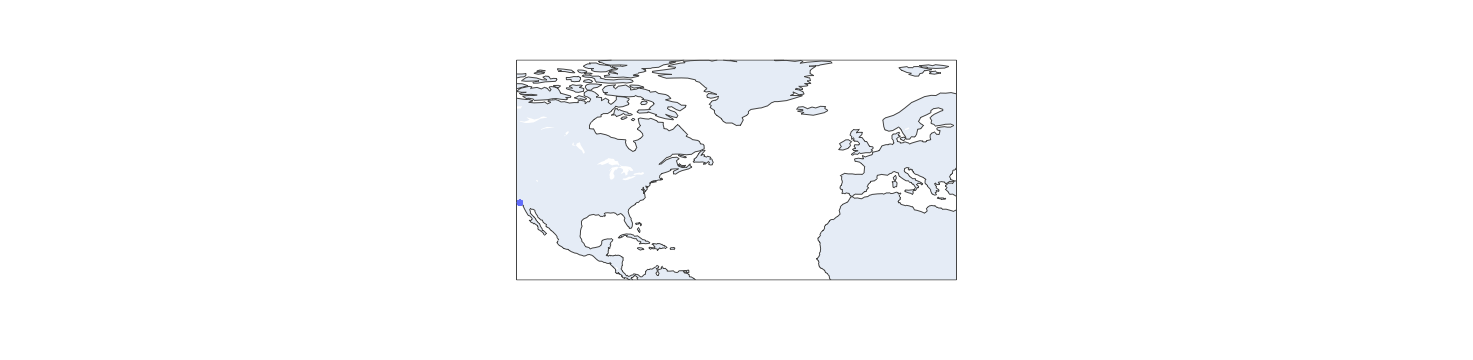

In [10]:
def build_outlier_filter(data: pd.DataFrame, col: str, q_offset: float = 2, only_upper: bool = False):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1 

    if only_upper:
        return ~(data[col] <= Q3 + q_offset * IQR)
    
    return ~((data[col] >= Q1 - q_offset * IQR) & (data[col] <= Q3 + q_offset * IQR))

lat_filter = build_outlier_filter(stations, 'lat')
lon_filter = build_outlier_filter(stations, 'lon')
fig = px.scatter_geo(stations[lat_filter | lon_filter], lat='lat', lon='lon')
fig.update_geos(fitbounds="locations")

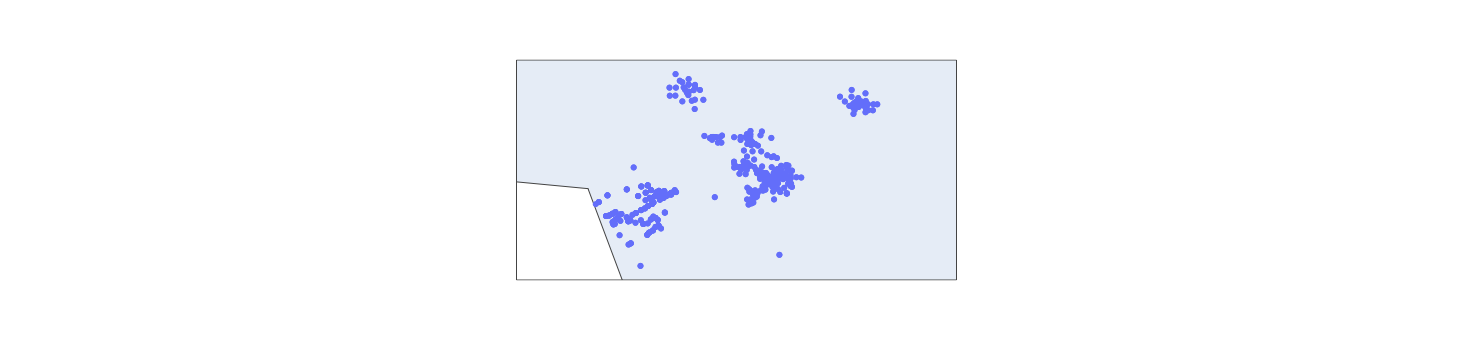

In [11]:
fig = px.scatter_geo(stations[~(lat_filter | lon_filter)], lat='lat', lon='lon')
fig.update_geos(fitbounds="locations")

In [12]:
valid_locations = stations[~(lat_filter | lon_filter)][['lat', 'lon']]
valid_locations

,lat,lon
0,34.025841,-118.238213
1,34.048500,-118.258537
2,34.045540,-118.256668
3,34.050480,-118.254590
4,34.046612,-118.262733
...,...,...
362,33.976189,-118.418419
363,34.094349,-118.326363
364,34.060791,-118.309067
365,34.020969,-118.335197


In [13]:
geo_filter = (train['start_lat'].isin(valid_locations['lat'])) & \
        (train['start_lon'].isin(valid_locations['lon'])) & \
        (train['end_lat'].isin(valid_locations['lat'])) & \
        (train['end_lon'].isin(valid_locations['lon']))

train = train[geo_filter]

In [14]:
duration_filter = build_outlier_filter(train, 'duration', q_offset=5, only_upper=True)

train = train[~duration_filter]
# train = train[train['duration'] <= 60 * 5]

In [15]:
cleaning_pipe.append(lambda data: data.dropna())
train = train.dropna()
train

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443
5,63406498,30,2017-12-16 15:18:00,2017-12-16 15:48:00,34.135250,-118.132370,34.135250,-118.132370,05768,0.0,Round Trip,Walk-up,4158,4158
6,25033469,11,2017-04-15 22:02:00,2017-04-15 22:13:00,34.045181,-118.250237,34.053570,-118.266357,06527,30.0,One Way,Monthly Pass,3067,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,83666862,17,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,30.0,One Way,Monthly Pass,3032,4220
699996,132547303,9,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,30.0,One Way,Monthly Pass,3036,3014
699997,67332628,6,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,365.0,One Way,Flex Pass,3032,3007
699998,114846232,3,2019-02-04 14:16:00,2019-02-04 14:19:00,34.045181,-118.250237,34.045540,-118.256668,12195,1.0,One Way,Walk-up,3067,3006


In [16]:
def set_datetime_types(data: pd.DataFrame):
    data.start_time = pd.to_datetime(data.start_time)
    data.end_time = pd.to_datetime(data.end_time)    

    return data

cleaning_pipe.append(set_datetime_types)
train = set_datetime_types(train)

In [17]:
ID_COLUMS = ['trip_id', 'bike_id', 'start_station', 'end_station']
TIME_COLUMS = ['start_time', 'start_time', 'duration']
GEO_COLUMNS = ['start_lat', 'start_lon', 'end_lat', 'end_lon']
TARGET = ['plan_duration', 'passholder_type']

In [18]:
train[TARGET].groupby(by='passholder_type').mean()

,plan_duration
passholder_type,
Annual Pass,365.000000
Flex Pass,365.000000
Monthly Pass,30.538824
One Day Pass,1.000000
Testing,999.000000
Walk-up,11.778632


In [19]:
train[train.passholder_type == 'Testing']

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
24398,132008969,1,2019-11-03 11:56:52,2019-11-03 11:57:16,33.984928,-118.469963,33.984928,-118.469963,15483,999.0,Round Trip,Testing,4347,4347
48251,129898045,18,2019-09-28 10:53:00,2019-09-28 11:11:00,34.150688,-118.366127,34.152000,-118.350601,15850,999.0,One Way,Testing,4418,4425
62890,129538183,33,2019-09-22 10:02:00,2019-09-22 10:35:00,33.997231,-118.445969,33.997231,-118.445969,15114,999.0,Round Trip,Testing,4333,4333
78386,116990214,2,2019-03-08 12:50:00,2019-03-08 12:52:00,34.025841,-118.238213,34.025841,-118.238213,15892,999.0,One Way,Testing,3000,3000
88559,133598990,9,2019-12-05 09:12:20,2019-12-05 09:21:51,33.994850,-118.417961,33.980789,-118.414902,15723,999.0,One Way,Testing,4460,4394
96508,116855271,1,2019-03-06 14:03:00,2019-03-06 14:04:00,34.025841,-118.238213,34.025841,-118.238213,16215,999.0,Round Trip,Testing,3000,3000
106748,116856954,1,2019-03-06 14:36:00,2019-03-06 14:37:00,34.025841,-118.238213,34.025841,-118.238213,16215,999.0,Round Trip,Testing,3000,3000
137983,116856473,1,2019-03-06 14:27:00,2019-03-06 14:28:00,34.025841,-118.238213,34.025841,-118.238213,16215,999.0,Round Trip,Testing,3000,3000
140456,127268537,39,2019-08-14 15:15:00,2019-08-14 15:54:00,33.995560,-118.481552,34.014309,-118.491341,15969,999.0,One Way,Testing,4345,4344
144667,142601654,10,2020-05-26 19:42:00,2020-05-26 19:52:00,33.984341,-118.471550,33.984341,-118.471550,15964,999.0,Round Trip,Testing,4346,4346


In [20]:
train = train[train.passholder_type != 'Testing']

In [21]:
def expand_time(data: pd.DataFrame):
    data['year'] = data['start_time'].dt.year
    data['hour'] = data['start_time'].dt.hour
    data['day'] = data['start_time'].dt.day
    data['month'] = data['start_time'].dt.month
    data['day_of_week'] = data['start_time'].dt.day_of_week
    data['date'] = data['start_time'].dt.to_period('D')
    data['hours'] = data['start_time'].dt.to_period('H')
    data['start_hour'] = data['start_time'].dt.hour
    data['end_hour'] = data['end_time'].dt.hour

    return data

train = expand_time(train)

/Users/aast/opt/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/aast/opt/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/aast/opt/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [22]:
# Calcula distancias entre estaciones de inicio y fin

def set_station_dist(data: pd.DataFrame):
    def get_distance(row: pd.Series):
        origin = (row['start_lat'], row['start_lon'])
        dest = (row['end_lat'], row['end_lon'])

        return distance.geodesic(origin, dest).meters


    data['distance'] = data.apply(get_distance, axis=1)

    return data

cleaning_pipe.append(set_station_dist)

train = set_station_dist(train)

## 1.3 Observaciones

In [ ]:
trips_by_start_station = train[['start_station', 'start_lon', 'start_lat']].value_counts().reset_index().rename(columns={0: 'count'})
trips_by_end_station = train[['end_station', 'end_lon', 'end_lat']].value_counts().reset_index().rename(columns={0: 'count'})

fig1 = px.scatter_geo(trips_by_start_station, lat='start_lat', lon='start_lon', size='count', projection="natural earth", title='Cantidad de viajes por estación de inicio')
fig1.update_geos(fitbounds="locations")
fig1.show()

fig2 = px.scatter_geo(trips_by_end_station, lat='end_lat', lon='end_lon', size='count', color_discrete_sequence=['red'], projection="natural earth", title='Cantidad de viajes por estación final')
fig2.update_geos(fitbounds="locations")
fig2.show()

In [ ]:
arrive_counts = train.value_counts(subset=['end_station', 'hour', 'day_of_week']).rename('arrive_count')
leave_counts = train.value_counts(subset=['start_station', 'hour', 'day_of_week']).rename('leave_count')

station_traffic = pd.concat([arrive_counts, leave_counts], axis=1).reset_index().rename(columns={'level_0': 'station'}).sort_values(by=['day_of_week', 'hour'])
station_traffic['diff'] = station_traffic['arrive_count'] - station_traffic['leave_count']
station_traffic_date_avg = station_traffic.groupby(by=['day_of_week', 'hour']).mean().reset_index()
station_traffic_station_avg = station_traffic.groupby(by='station').mean().reset_index()
station_traffic

In [ ]:
fig1 = px.line(station_traffic_date_avg, color='day_of_week', x='hour', y='arrive_count', title='Cantidad de llegadas promedio por hora y día de la semana')
fig1.show()
fig2 = px.line(station_traffic_date_avg, color='day_of_week', x='hour', y='leave_count', title='Cantidad de salidas promedio por hora y día de la semana')
fig2.show()
fig3 = px.line(station_traffic_date_avg, color='day_of_week', x='hour', y='diff', title='Diferencia llegadas - salidas promedio por hora y día de la semana')
fig3.show()

In [ ]:
trip_by_pass = train[['distance', 'duration',  'passholder_type']].groupby(by=['passholder_type']).mean().reset_index()
trip_by_pass

fig = px.bar(trip_by_pass, x='passholder_type', y='distance', title='Distancia promedio de viaje por tipo de pase')
fig.show()
fig = px.bar(trip_by_pass, x='passholder_type', y='duration', title='Duración promedio de viaje por tipo de pase')
fig.show()


In [ ]:
px.box(train, x="passholder_type", y="duration")

In [ ]:
px.box(train, x="passholder_type", y="distance")

In [ ]:
trip_by_pass = train[['passholder_type', 'duration', 'distance']].groupby(by=['passholder_type']).mean()
trip_by_pass

In [ ]:
trips_by_station = train[['start_station', 'start_lon', 'start_lat', 'year']].value_counts().reset_index().rename(columns={0: 'count'}).sort_values(by=['year', 'count'])

px.scatter_geo(trips_by_station, lat='start_lat', lon='start_lon', size='count', animation_frame='year')

In [ ]:
trip_counts = train.value_counts(subset=['date', 'passholder_type']).reset_index().rename(columns={0: 'count'}).sort_values(by='date')

px.line(x=trip_counts['date'].astype(str), y=trip_counts['count'], color=trip_counts['passholder_type'], title='Número de viajes diarios / tipo de pase')

In [ ]:
trip_counts = train.value_counts(subset=['day_of_week', 'passholder_type']).reset_index().rename(columns={0: 'count'}).sort_values(by='day_of_week')

px.line(x=trip_counts['day_of_week'].astype(str), y=trip_counts['count'], color=trip_counts['passholder_type'], title='Promedio de viajes en la semana (0 lunes, 6 Domingo) / tipo de pase')

In [ ]:
trip_counts = train.value_counts(subset=['month', 'passholder_type']).reset_index().rename(columns={0: 'count'}).sort_values(by='month')

px.line(x=trip_counts['month'].astype(str), y=trip_counts['count'], color=trip_counts['passholder_type'], title='Promedio de viajes mensuales / tipo de pase')

In [ ]:
trip_counts = train.value_counts(subset=['year', 'passholder_type']).reset_index().rename(columns={0: 'count'}).sort_values(by='year')

px.line(x=trip_counts['year'], y=trip_counts['count'], color=trip_counts['passholder_type'], markers=True, title='Número de viajes anuales / tipo de pase')

In [ ]:
train.to_csv('processed.csv')

## 2. Construcción de modelo

In [3]:
train = pd.read_csv('processed.csv')

/tmp/ipykernel_21692/942935117.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('processed.csv')


In [4]:
train.columns

Index(['Unnamed: 0', 'trip_id', 'duration', 'start_time', 'end_time',
       'start_lat', 'start_lon', 'end_lat', 'end_lon', 'bike_id',
       'plan_duration', 'trip_route_category', 'passholder_type',
       'start_station', 'end_station', 'year', 'hour', 'day', 'month',
       'day_of_week', 'date', 'hours', 'start_hour', 'end_hour', 'distance'],
      dtype='object')

In [5]:
model_features = ['duration', 'trip_route_category', 'month', 'day_of_week', 'distance', 'start_hour', 'end_hour']
categorical_features = ['trip_route_category', 'month', 'day_of_week']
target_categories = train['passholder_type'].unique().tolist()
target = 'passholder_type'

train_set = train[model_features + [target]]

In [6]:
train_set.loc[:, 'start_hour'] = np.sin(train_set.loc[:, 'start_hour'])
train_set.loc[:, 'end_hour'] = np.sin(train_set.loc[:, 'end_hour'])

/tmp/ipykernel_21692/2541715898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.loc[:, 'start_hour'] = np.sin(train_set.loc[:, 'start_hour'])
/tmp/ipykernel_21692/2541715898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.loc[:, 'end_hour'] = np.sin(train_set.loc[:, 'end_hour'])


In [ ]:
from sklearn.preprocessing import OneHotEncoder

def encode_category(data: pd.DataFrame, col: str, label: str = None):
    if label is None:
        label = col
    
    encoder = OneHotEncoder(sparse=False)
    col_encoded = encoder.fit_transform(data[[col]])
    
    feature_names = encoder.get_feature_names_out(input_features=[label])
    col_encoded_df = pd.DataFrame(col_encoded, columns=feature_names)

    return pd.concat([data.drop(columns=col).reset_index(drop=True), col_encoded_df.reset_index(drop=True)], axis=1)


for category in categorical_features:
    train_set = encode_category(train_set, category)

train_set

In [ ]:
raw_labels_numerical = train_set[target].map({cat: idx for idx, cat  in enumerate(target_categories)})
    
train_labels = tf.keras.utils.to_categorical(raw_labels_numerical.to_numpy(), len(target_categories), dtype="float32")
train_labels

In [ ]:
train_features = train_set.drop(columns=target)

In [10]:
# from sklearn.model_selection import train_test_split
# 
# X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

for train_i, test_i in kfold.split(train_features, train_set[target]):
    X_train = train_features.loc[train_i]
    y_train = train_labels[train_i]
   
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
      
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(train_features.loc[test_i], train_labels[test_i]), callbacks=[
        tf.keras.callbacks.ModelCheckpoint('nn.hdf5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='auto',
                                period=1,
                                save_weights_only=False),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    ])
    


2022-12-05 18:55:33.799208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 18:55:34.130410: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9626280 exceeds 10% of free system memory.
2022-12-05 18:55:34.772725: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 96262800 exceeds 10% of free system memory.
2022-12-05 18:55:35.100129: W tensorflow/core/platform/profile_utils/cpu_utils.cc:118] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


Epoch 1/100
15039/15042 [============================>.] - ETA: 0s - loss: 1.1369 - accuracy: 0.6465

2022-12-05 19:00:23.425699: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24065800 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.65919, saving model to nn.hdf5
15042/15042 [==============================] - 321s 21ms/step - loss: 1.1368 - accuracy: 0.6465 - val_loss: 0.9439 - val_accuracy: 0.6592
Epoch 2/100
15042/15042 [==============================] - ETA: 0s - loss: 0.9130 - accuracy: 0.6676
Epoch 2: val_accuracy improved from 0.65919 to 0.67175, saving model to nn.hdf5
15042/15042 [==============================] - 322s 21ms/step - loss: 0.9130 - accuracy: 0.6676 - val_loss: 0.9066 - val_accuracy: 0.6717
Epoch 3/100
15041/15042 [============================>.] - ETA: 0s - loss: 0.9046 - accuracy: 0.6690
Epoch 3: val_accuracy did not improve from 0.67175
15042/15042 [==============================] - 320s 21ms/step - loss: 0.9046 - accuracy: 0.6690 - val_loss: 0.9014 - val_accuracy: 0.6716
Epoch 4/100
15039/15042 [============================>.] - ETA: 0s - loss: 0.9022 - accuracy: 0.6702
Epoch 4: val_accuracy did not improve from 0.67175
15042/15042 [==========